In [ ]:
pip install tensorflow


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!ls 'output3'

ls: cannot access 'output3': No such file or directory


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import metrics

from sklearn.utils import class_weight
from collections import Counter

import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join

import pandas as pd

In [ ]:
train_loc = '/content/drive/MyDrive/final project/output3/train'
test_loc = '/content/drive/MyDrive/final project/output3/val'

In [ ]:
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory=train_loc, target_size=(224,224))
tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory=test_loc, target_size=(224,224))

Found 5524 images belonging to 8 classes.
Found 1383 images belonging to 8 classes.


In [ ]:
diagnosis_csv = '/content/drive/MyDrive/final project/output3/patient_diagnosis.csv'
diagnosis = pd.read_csv(diagnosis_csv, names=['pId', 'diagnosis'])
diagnosis.head()

,pId,diagnosis
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [ ]:
categories = diagnosis['diagnosis'].unique()
categories

array(['URTI', 'Healthy', 'Asthma', 'COPD', 'LRTI', 'Bronchiectasis',
       'Pneumonia', 'Bronchiolitis'], dtype=object)

In [ ]:
rn = ResNet50(weights='imagenet')
rn.summary()

x  = rn.output
prediction = Dense(8, activation='softmax', name='pred')(x)
model = Model(inputs=rn.input, outputs=prediction)

102967424/102967424 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

In [ ]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-25:]:
    layer.trainable = True
    print("Layer '%s' is trainable" % layer.name)

Layer 'conv5_block1_add' is trainable
Layer 'conv5_block1_out' is trainable
Layer 'conv5_block2_1_conv' is trainable
Layer 'conv5_block2_1_bn' is trainable
Layer 'conv5_block2_1_relu' is trainable
Layer 'conv5_block2_2_conv' is trainable
Layer 'conv5_block2_2_bn' is trainable
Layer 'conv5_block2_2_relu' is trainable
Layer 'conv5_block2_3_conv' is trainable
Layer 'conv5_block2_3_bn' is trainable
Layer 'conv5_block2_add' is trainable
Layer 'conv5_block2_out' is trainable
Layer 'conv5_block3_1_conv' is trainable
Layer 'conv5_block3_1_bn' is trainable
Layer 'conv5_block3_1_relu' is trainable
Layer 'conv5_block3_2_conv' is trainable
Layer 'conv5_block3_2_bn' is trainable
Layer 'conv5_block3_2_relu' is trainable
Layer 'conv5_block3_3_conv' is trainable
Layer 'conv5_block3_3_bn' is trainable
Layer 'conv5_block3_add' is trainable
Layer 'conv5_block3_out' is trainable
Layer 'avg_pool' is trainable
Layer 'predictions' is trainable
Layer 'pred' is trainable


In [ ]:
opt = Adam(learning_rate=0.000001)
model.compile(optimizer=opt, loss=categorical_crossentropy,
              metrics=['accuracy', 'mae'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
checkpoint = ModelCheckpoint("rn_base_res.h5", monitor='val_accuracy', verbose=2,
                             save_best_only=True, save_weights_only=False, mode='auto')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=2, mode='auto')

In [ ]:
counter = Counter(traindata.classes)
max_val = float(max(counter.values()))
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
class_weights

{0: 1151.25,
 1: 55.48192771084337,
 2: 35.9765625,
 3: 1.0,
 4: 17.91828793774319,
 5: 184.2,
 6: 20.19736842105263,
 7: 23.737113402061855}

In [ ]:
hist = model.fit(traindata, steps_per_epoch=traindata.samples//traindata.batch_size, validation_data=testdata,
                 class_weight=class_weights, validation_steps=testdata.samples//testdata.batch_size,
                 epochs=100,callbacks=[checkpoint,early])

Epoch 1/100
172/172 [==============================] - ETA: 0s - loss: 13.4895 - accuracy: 0.6861 - mae: 0.2174
Epoch 1: val_accuracy improved from 0.64172 to 0.65044, saving model to rn_base_res.h5
172/172 [==============================] - 79s 459ms/step - loss: 13.4895 - accuracy: 0.6861 - mae: 0.2174 - val_loss: 2.0388 - val_accuracy: 0.6504 - val_mae: 0.2174
Epoch 2/100
172/172 [==============================] - ETA: 0s - loss: 13.4216 - accuracy: 0.6917 - mae: 0.2173
Epoch 2: val_accuracy improved from 0.65044 to 0.65843, saving model to rn_base_res.h5
172/172 [==============================] - 78s 454ms/step - loss: 13.4216 - accuracy: 0.6917 - mae: 0.2173 - val_loss: 2.0376 - val_accuracy: 0.6584 - val_mae: 0.2174
Epoch 3/100
172/172 [==============================] - ETA: 0s - loss: 13.4576 - accuracy: 0.7039 - mae: 0.2173
Epoch 3: val_accuracy improved from 0.65843 to 0.67224, saving model to rn_base_res.h5
172/172 [==============================] - 77s 450ms/step - loss: 13.

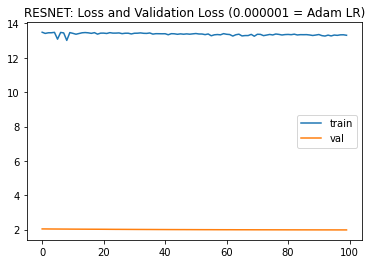

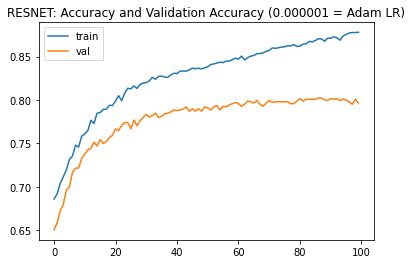

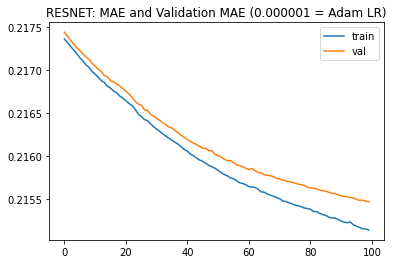

In [ ]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.title('RESNET: Loss and Validation Loss (0.000001 = Adam LR)')
plt.legend();
plt.show()

plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='val')
plt.title('RESNET: Accuracy and Validation Accuracy (0.000001 = Adam LR)')
plt.legend();
plt.show()

plt.plot(hist.history['mae'], label='train')
plt.plot(hist.history['val_mae'], label='val')
plt.title('RESNET: MAE and Validation MAE (0.000001 = Adam LR)')
plt.legend();
plt.show()

In [ ]:
model.evaluate(testdata)

44/44 [==============================] - 14s 310ms/step - loss: 1.9808 - accuracy: 0.7975 - mae: 0.2155


[1.9807555675506592, 0.7975415587425232, 0.2154640555381775]

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
# predict classes of validation dataset
val_predict = model.predict(testdata)

44/44 [==============================] - 14s 314ms/step


In [ ]:
import numpy as np


In [ ]:
predict_class = np.argmax(val_predict, axis=1)
predict_class = predict_class.tolist()

In [ ]:
labels = ['Asthma','Bronchiectasis','Bronchiolitis','COPD','Healthy','LRTI','Pneumonia','URTI']
report = classification_report(testdata.classes, predict_class, target_names=labels)
print(report)

                precision    recall  f1-score   support

        Asthma       0.00      0.00      0.00         2
Bronchiectasis       0.03      0.05      0.04        21
 Bronchiolitis       0.08      0.03      0.04        32
          COPD       0.83      0.79      0.81      1150
       Healthy       0.03      0.09      0.05        65
          LRTI       0.00      0.00      0.00         7
     Pneumonia       0.06      0.04      0.04        57
          URTI       0.05      0.02      0.03        49

      accuracy                           0.67      1383
     macro avg       0.14      0.13      0.13      1383
  weighted avg       0.70      0.67      0.68      1383



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cm = confusion_matrix(testdata.classes, predict_class)
cm_df = pd.DataFrame(cm,
                     index = ['Asthma','Bronchiectasis','Bronchiolitis','COPD','Healthy','LRTI','Pneumonia','URTI'],
                     columns = ['Asthma','Bronchiectasis','Bronchiolitis','COPD','Healthy','LRTI','Pneumonia','URTI'])

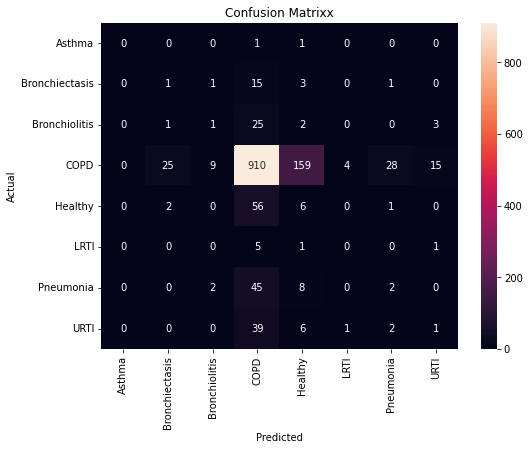

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d')
plt.title("Confusion Matrixx")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
